In [1]:
%load_ext autoreload
%autoreload 3
%load_ext nb_black
%load_ext dotenv
%dotenv
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

<IPython.core.display.Javascript object>

In [51]:
import os
import functools
import re
import pathlib

root = pathlib.Path(os.environ["DATA_ROOT"]).expanduser()

<IPython.core.display.Javascript object>

In [4]:
import numpy as np

# import numba as nb
import plotnine as p9
import pandas as pd

# import seaborn as sns
from datetime import datetime


%matplotlib inline

<IPython.core.display.Javascript object>

In [8]:
df = pd.read_csv(root / "ocr-output.csv").query("frame_num >= 16")

<IPython.core.display.Javascript object>

In [9]:
def make_monotonic(s, window_radius=11, threshold=1e-3):
    assert (
        s.index == np.arange(len(s))
    ).all(), "Series must begin with sorted default index."

    s_out = s.copy()

    s = s.dropna()
    diffs = s.diff()

    while (diffs < -threshold).any():
        # Find values on either side of the largest current negative diff.
        arg_min_diff = diffs.argmin()
        val_left = s.iloc[arg_min_diff - 1]
        val_right = s.iloc[arg_min_diff]

        # Decide whether we'll null out the left or the right value.
        window = s.iloc[
            max(0, arg_min_diff - window_radius) : min(
                len(s), arg_min_diff + window_radius
            )
        ]
        wmd = window.median()
        if abs(val_left - wmd) < abs(val_right - wmd):
            # Right is farther away, null it out.
            s.iloc[arg_min_diff] = np.nan
        else:
            # Null out left.
            s.iloc[arg_min_diff - 1] = np.nan

        s = s.dropna()
        diffs = s.diff()

    return s_out.combine(s, lambda a, b: b)


<IPython.core.display.Javascript object>

In [43]:
def _process_time_ppocr(s):
    try:
        if np.isnan(s):
            return None
    except TypeError:
        pass
    if len(s) < 5:
        return None
    s = s[-5:]
    a, m, b = s[:2], s[2], s[3:]
    if m != ":":
        return None
    try:
        return 60 * float(a) + float(b)
    except ValueError:
        return None


def _process_time_ssocr(s):
    s = s.strip("._")
    if len(s) != 5:
        return None
    a, m, b = s[:2], s[2], s[3:]
    if m != "1":
        return None
    try:
        return 60 * float(a) + float(b)
    except ValueError:
        return None


def process_time_ppocr(series):
    return series.apply(_process_time_ppocr)


def process_time_ssocr(series):
    return series.apply(_process_time_ssocr)


def make_it_float(s):
    return pd.to_numeric(s, errors="coerce")


def process_field(
    df,
    landmark,
    ppocr_fn=make_it_float,
    ssocr_fn=make_it_float,
    enforce_monotonicity=False,
    debug=False,
):
    _df = (
        df.query("landmark == @landmark")
        .reset_index(drop=True)
        .assign(
            _ppocr=lambda f: ppocr_fn(f.inference_text),
            _ssocr=lambda f: ssocr_fn(f.ssocr),
            _fused=lambda f: f._ppocr.combine_first(f._ssocr),
            # Null out sites where the two ocrs disagree.
            _valid_mask=lambda f: f._ppocr.notna() & f._ssocr.notna(),
            fused=lambda f: f._fused.where(
                ~((f._ppocr != f._ssocr) & f._valid_mask), None
            ),
        )
    )

    if enforce_monotonicity:
        _df = _df.assign(fused=lambda f: make_monotonic(f.fused))

    if debug:
        return _df.rename(columns={"fused": landmark})

    return _df.loc[:, ["frame_num", "fused"]].rename(columns={"fused": landmark})

<IPython.core.display.Javascript object>

In [46]:
time_df = process_field(
    df,
    "TIME",
    ppocr_fn=process_time_ppocr,
    ssocr_fn=process_time_ssocr,
    enforce_monotonicity=True,
)


<IPython.core.display.Javascript object>

In [49]:
speed_df = process_field(df, "SPEED")
watts_df = process_field(df, "WATTS")
cadence_df = process_field(df, "CADENCE")
distance_df = process_field(df, "DISTANCE", enforce_monotonicity=True)
time_df = process_field(
    df,
    "TIME",
    ppocr_fn=process_time_ppocr,
    ssocr_fn=process_time_ssocr,
    enforce_monotonicity=True,
)
calories_df = process_field(
    df,
    "CALORIES",
    enforce_monotonicity=True,
)


# p9.ggplot(calories_df, p9.aes("frame_num", "CALORIES")) + p9.geom_line()

<IPython.core.display.Javascript object>

In [103]:
tr_table = pd.read_csv("top-row-states.csv").rename(columns=str.upper)


def _impute(row, tr):
    indices = ["SPEED", "WATTS", "CADENCE"]

    vals = row.iloc[1:]
    if vals.isna().all():
        return row

    # distances = np.sqrt((tr - vals) ** 2).mean(axis="columns")
    distances = (tr != vals).sum(axis="columns")

    min_idx = distances.idxmin()
    min_val = distances.loc[min_idx]

    if min_val <= 2:
        row.loc[indices] = tr.loc[min_idx]
        return row
    else:
        row.loc[indices] = np.nan
        return row


def impute_top_row(df, tr=tr_table):
    return df.apply(lambda e: _impute(e, tr), axis="columns")


toprow_df = impute_top_row(
    functools.reduce(
        lambda f, g: f.merge(g, on="frame_num", how="inner"),
        [speed_df, watts_df, cadence_df],
    )
)

<IPython.core.display.Javascript object>

In [105]:
rogue_df = functools.reduce(
    lambda f, g: f.merge(g, on="frame_num", how="inner"),
    [toprow_df, distance_df, time_df, calories_df],
)

rogue_df.describe()

rogue_df.notna().mean()

,frame_num,SPEED,WATTS,CADENCE,DISTANCE,TIME,CALORIES
count,8077.000000,7981.000000,7981.000000,7981.000000,1564.000000,7363.000000,7256.000000
mean,4054.000000,21.013081,228.281794,56.520110,1.281820,133.852913,20.427329
std,2331.773395,3.851449,105.421086,10.334748,0.337176,78.456817,16.304193
min,16.000000,12.200000,53.000000,33.000000,0.000000,0.000000,0.000000
25%,2035.000000,17.800000,136.000000,48.000000,1.207500,65.000000,5.000000
50%,4054.000000,22.300000,242.000000,60.000000,1.360000,134.000000,17.000000
75%,6073.000000,23.800000,298.000000,64.000000,1.470000,202.000000,34.250000
max,8092.000000,27.900000,466.000000,75.000000,1.571000,270.000000,51.000000


frame_num    1.000000
SPEED        0.988114
WATTS        0.988114
CADENCE      0.988114
DISTANCE     0.193636
TIME         0.911601
CALORIES     0.898353
dtype: float64

<IPython.core.display.Javascript object>

In [185]:
def _process_time_ppocr(s):
    try:
        if np.isnan(s):
            return None
    except TypeError:
        pass
    if len(s) < 5:
        return None
    s = s[-5:]
    a, m, b = s[:2], s[2], s[3:]
    if m != ":":
        return None
    try:
        return 60 * float(a) + float(b)
    except ValueError:
        return None


def _process_time_ssocr(s):
    s = s.strip("._")
    if len(s) != 5:
        return None
    a, m, b = s[:2], s[2], s[3:]
    if m != "1":
        return None
    try:
        return 60 * float(a) + float(b)
    except ValueError:
        return None


def process_time(df):
    _df = (
        df.query("landmark == 'TIME'")
        .assign(
            ppocr_sec=lambda f: f.inference_text.apply(_process_time_ppocr),
            ssocr_sec=lambda f: f.ssocr.apply(_process_time_ssocr),
            _fused_sec=lambda f: f.ppocr_sec.combine_first(f.ssocr_sec),
            _bd=lambda f: f.ppocr_sec.notna() & f.ssocr_sec.notna(),
            fused_sec=lambda f: f._fused_sec.where(
                ~((f.ppocr_sec != f.ssocr_sec) & f._bd), -1
            ),
        )
        .reset_index(drop=True)
        .assign(TIME=lambda f: make_monotonic(f.fused_sec.astype(float)))
    )

    return _df


time_df = process_time(df).loc[
    :,
    [
        "frame_num",
        # "inference_text",
        # "ssocr",
        # "ppocr_sec",
        # "ssocr_sec",
        # "fused_sec",
        # "frame",
        "TIME",
    ],
]

# (
#     p9.ggplot(pdf, p9.aes("frame_num", "fused_sec"))
#     + p9.geom_point()
#     + p9.theme(figure_size=(10, 7))
# )

<IPython.core.display.Javascript object>

In [187]:
def parse_float_from_string(input_string):
    # search for the pattern in the input string
    if not isinstance(input_string, str):
        return None
    match = re.search(r"\b\d{1,2}\.\d{2}\b", input_string)
    # if a match is found, parse the matched substring as a float and return it
    if match:
        return float(match.group())
    # if no match is found, return None
    else:
        return None


_process_distance_ppocr = parse_float_from_string
_process_distance_ssocr = parse_float_from_string


def process_distance(df):
    _df = (
        df.query("landmark == 'DISTANCE'")
        .reset_index(drop=True)
        .assign(
            _ppocr=lambda f: f.inference_text.apply(_process_distance_ppocr),
            _ssocr=lambda f: f.ssocr.apply(_process_distance_ssocr),
            _fused=lambda f: f._ppocr.combine_first(f._ssocr),
            _bd=lambda f: f._ppocr.notna() & f._ssocr.notna(),
            fused=lambda f: f._fused.where(~((f._ppocr != f._ssocr) & f._bd), None),
            DISTANCE=lambda f: make_monotonic(f.fused.astype(float)),
        )
    )

    return _df


distance_df = process_distance(df).loc[
    :,
    [
        "frame_num",
        # "inference_text",
        # "ssocr",
        # "_ppocr",
        # "_ssocr",
        # "_fused",
        # "fused",
        # "frame",
        "DISTANCE",
    ],
]


# (
#     p9.ggplot(pdf, p9.aes("frame_num", "fused"))
#     + p9.geom_point()
#     + p9.theme(figure_size=(10, 7))
# )

<IPython.core.display.Javascript object>

/home/mike/.pyenv/versions/exma-3.10.11/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


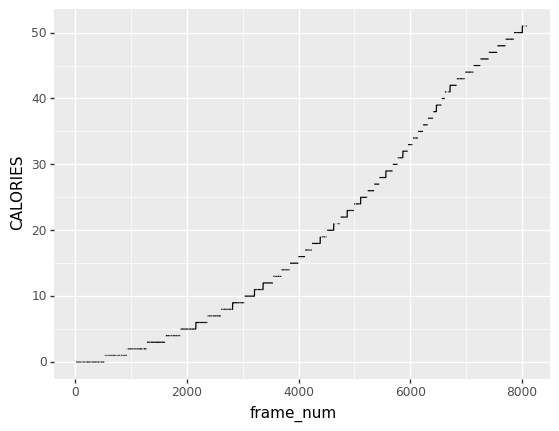

<ggplot: (8754543206394)>

<IPython.core.display.Javascript object>

In [196]:
_process_calories_ppocr = lambda e: pd.to_numeric(e, errors="coerce")
_process_calories_ssocr = lambda e: pd.to_numeric(e, errors="coerce")


def process_calories(df):
    _df = (
        df.query("landmark == 'CALORIES'")
        .reset_index(drop=True)
        .assign(
            _ppocr=lambda f: f.inference_text.apply(_process_calories_ppocr),
            _ssocr=lambda f: f.ssocr.apply(_process_calories_ssocr),
            _fused=lambda f: f._ppocr.combine_first(f._ssocr),
            _bd=lambda f: f._ppocr.notna() & f._ssocr.notna(),
            fused=lambda f: f._fused.where(~((f._ppocr != f._ssocr) & f._bd), None),
            CALORIES=lambda f: make_monotonic(f.fused.astype(float)),
        )
    )

    return _df


calories_df = process_calories(df).loc[
    :,
    [
        "frame_num",
        # "inference_text",
        # "ssocr",
        # "_ppocr",
        # "_ssocr",
        # "_fused",
        # "fused",
        # "frame",
        "CALORIES",
    ],
]

p9.ggplot(calories_df, p9.aes("frame_num", "CALORIES")) + p9.geom_line()

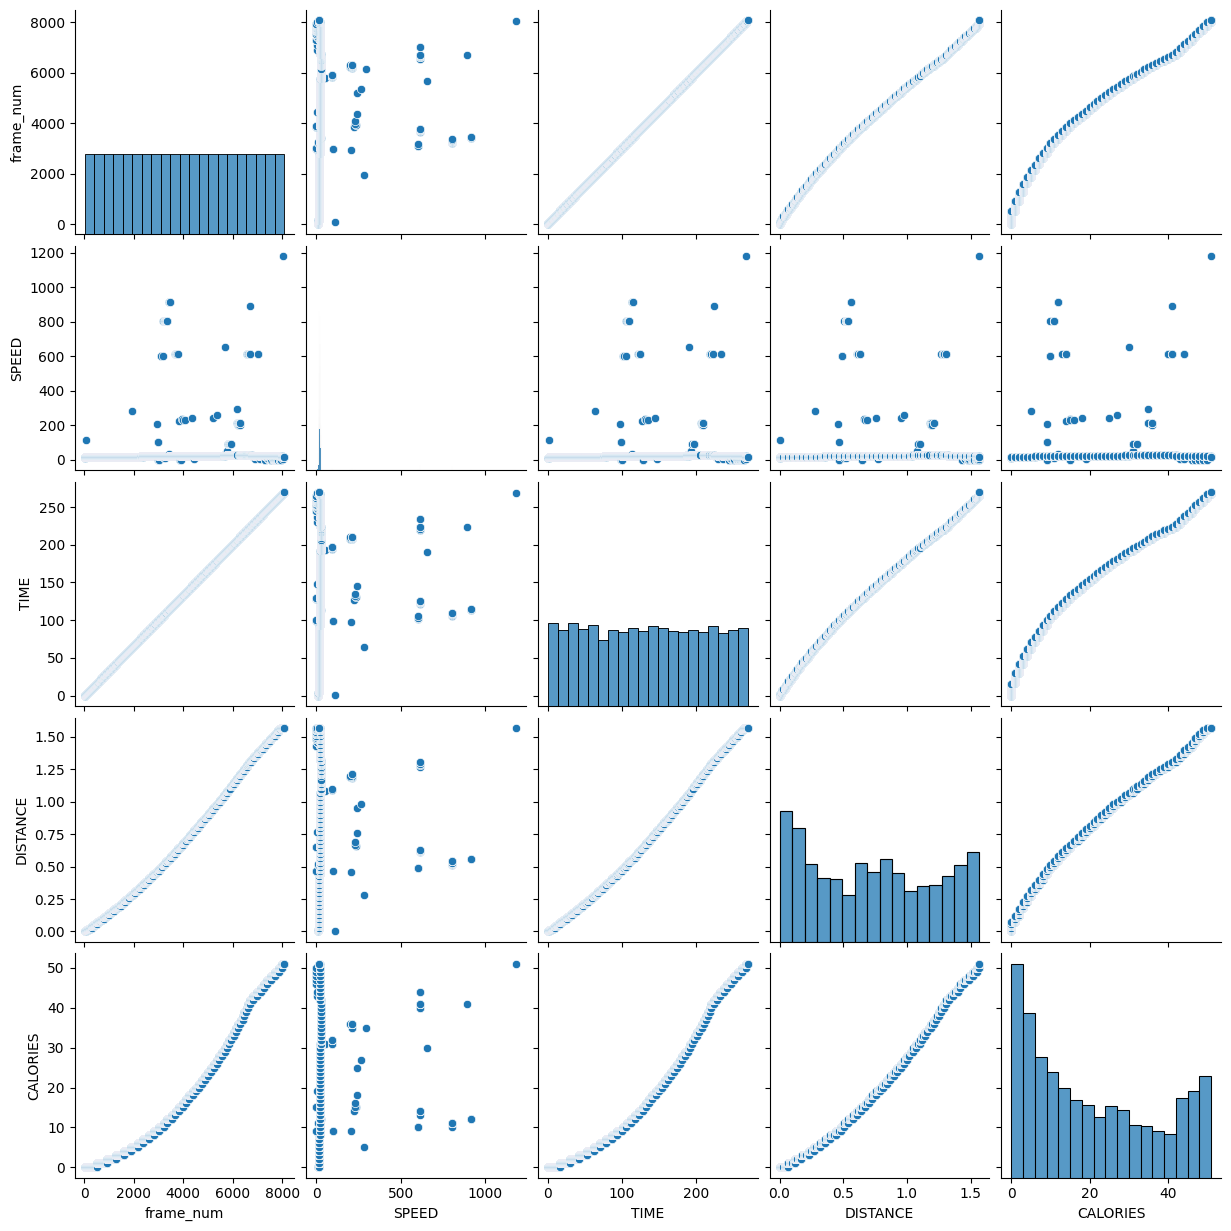

<IPython.core.display.Javascript object>

In [210]:
sns.pairplot(
    speed_df.merge(time_df, on="frame_num")
    .merge(distance_df, on="frame_num")
    .merge(calories_df, on="frame_num")
)